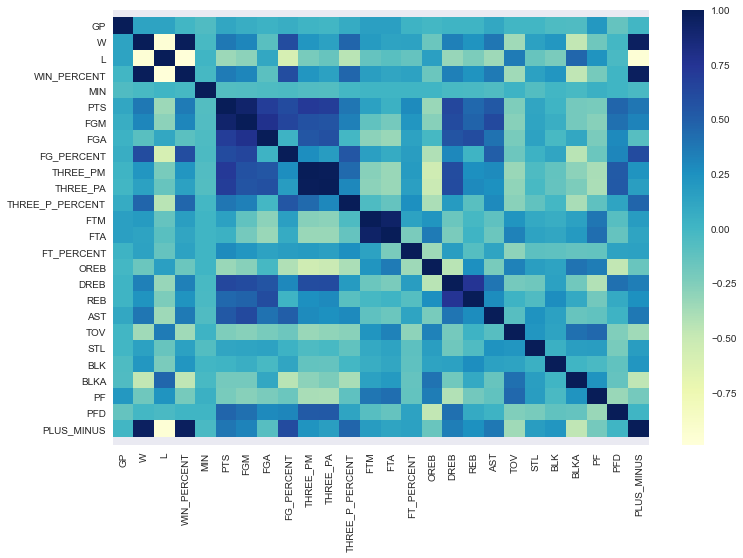

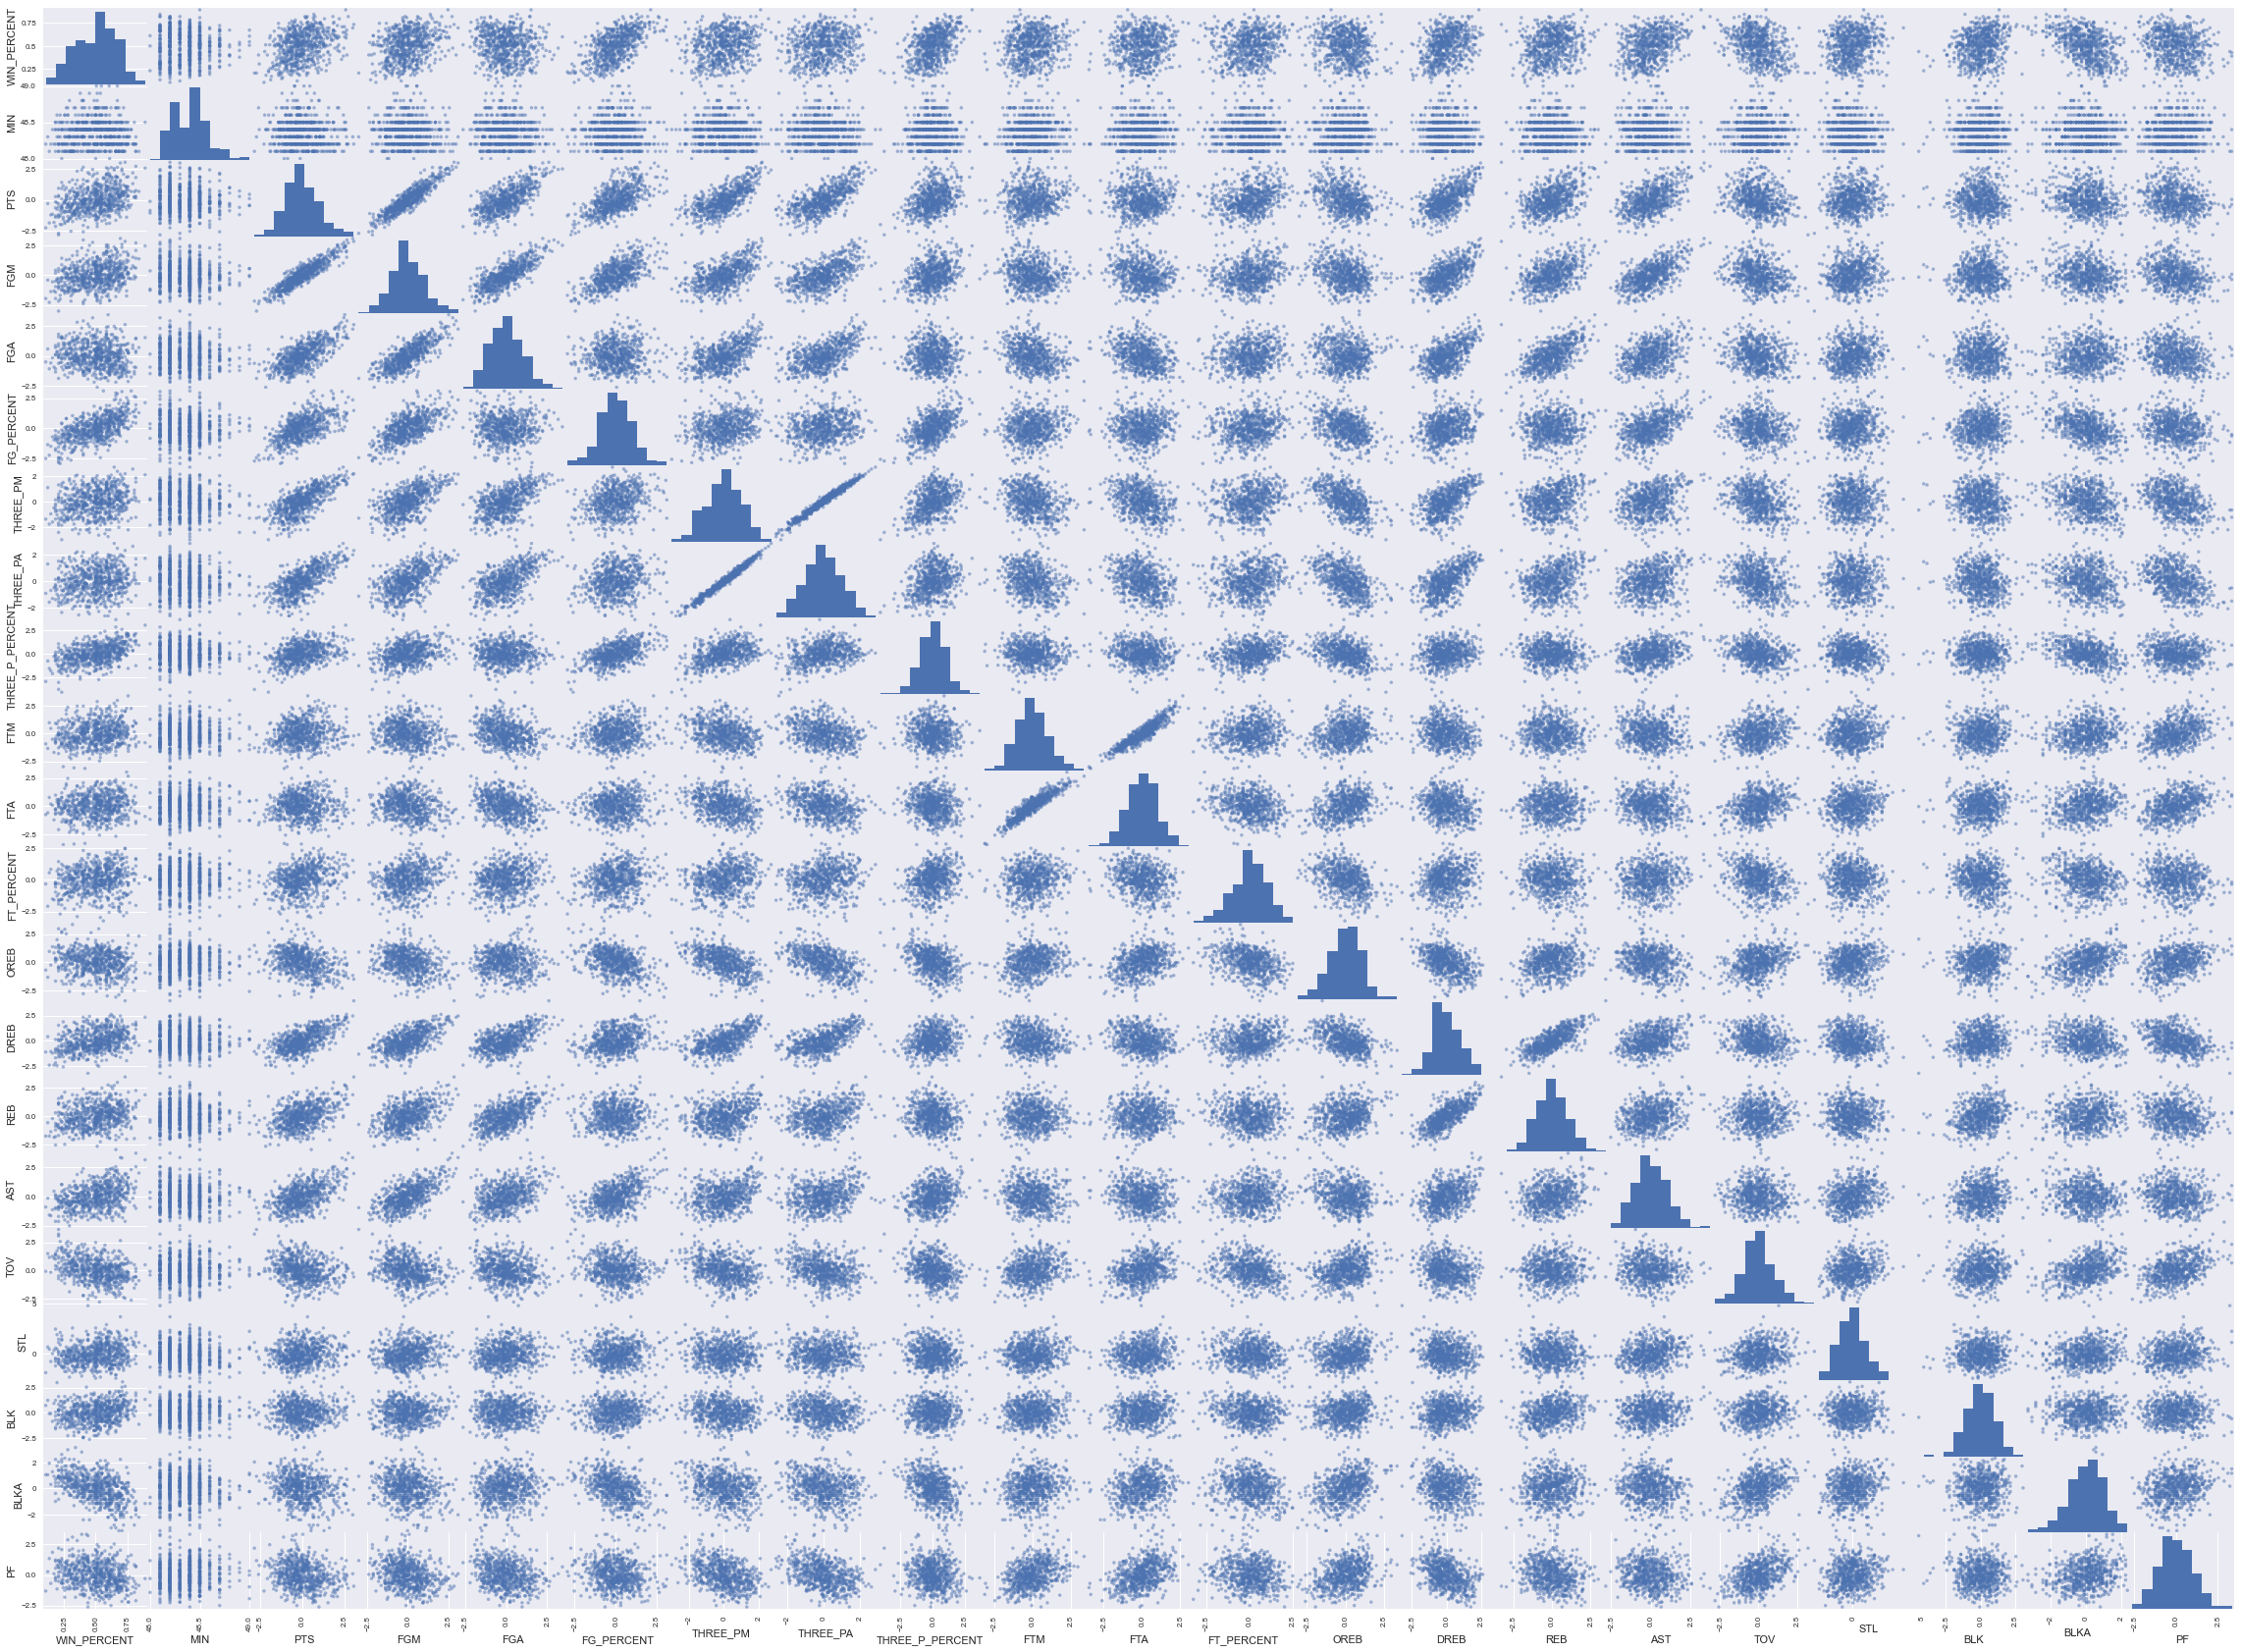

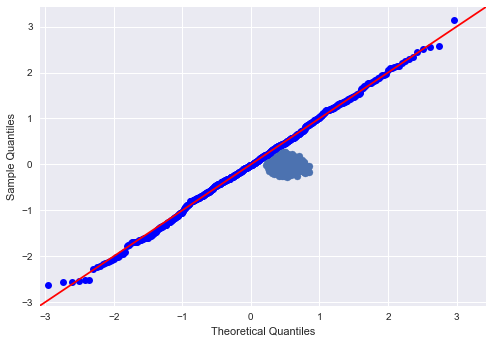

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import requests
# from selenium import webdriver
import re
import time
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pd.set_option('display.max_columns', 30)


# # Create list of seasons to look at
# seasons = ['1996-97', '1997-98', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08',
#             '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']


# # Scrapes stats.nba.com to get season average statistics using Selenium, creates Pandas dataframe from statistics, and concatenates each year's dataframe with the prior year
# def get_data(seasons_list):
#     statistics = pd.DataFrame()
#     for season in seasons_list:
#         url = 'https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=' + season + '&SeasonType=Regular%20Season'
#         driver = webdriver.Chrome(r"/Users/Robert/Downloads/chromedriver")
#         driver.get(url)
#         time.sleep(3)
#         table = driver.find_element_by_class_name('nba-stat-table__overflow')
#         remove_endline = table.text.split('\n')
#         row_to_string = ' '.join(remove_endline)
#         split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
#         separate_teams = split_lines.split('\n')
#         table_list = []
#         for row in separate_teams:
#             split_stats = row.split()
#             table_list.append(split_stats[-27:])
#         df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
#         df.insert(0, 'SEASON', season)
#         statistics = pd.concat([statistics, df], ignore_index = True)
#         driver.close()
#     return statistics

# statistics_df = get_data(seasons)
# statistics_df

# # Save large dataframe to file for use in analysis
# statistics_df.to_csv('nba_statistics_pergame.csv', index=False)



# Load dataframe and edit column names since numbers in the names, as well as percent signs and + and - don't work well with Python
stats_df = pd.read_csv('nba_statistics_pergame.csv')
stats_df.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df


# Set y and x values that we are interested in looking at, as well as columns that you want to do log transformations on
outcome = 'WIN_PERCENT'
x_cols = ['PTS', 'FGM', 'FGA', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'THREE_P_PERCENT', 'FTM', 'FTA', 'FT_PERCENT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
log_cols = ['PTS', 'FGM', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'BLK', 'BLKA']


# Get log values for those specific columns
for cols in stats_df[log_cols]:
    stats_df[cols] = np.log(stats_df[cols])
stats_df

# Normalized all values (including log transformed ones)
for col in stats_df[x_cols]:
    stats_df[col] = (stats_df[col] - stats_df[col].mean())/stats_df[col].std()
stats_df


# Create heatmap to investigate correlations between variables
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(stats_df.corr(), ax=ax, cmap='YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


# View variable correlations just with WIN_PERCENT
corr = stats_df.corr()
abs(corr).sort_values(by = 'WIN_PERCENT', ascending = False)['WIN_PERCENT']


# Create scatter matrix and histograms to see distribution shape of all variables (normal vs. skewed)
pd.plotting.scatter_matrix(stats_df.iloc[:, 5:-2], figsize=(40,30))



# Summary with ALL values with NO transformations for comparison
predictors = '+'.join(stats_df[x_cols])
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()



# Summary with ALL values log transformed for comparison
predictors = '+'.join(stats_df[x_cols])
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()


# -------------------------------------------------------------------------------------------------------------------------------------


# Summary with values that we decided to do log transformations on, as well as the ones we kept as is (i.e., potential ideal model)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()


# Initital refinement of variables
new_xcols = ['PTS', 'FGA', 'FTM', 'FTA', 'FT_PERCENT', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
predictors = '+'.join(new_xcols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()


# Check refined variables for multicolinearity
X = stats_df[new_xcols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(new_xcols, vif))


# Second refinement of variables
new_xcols2 = ['PTS', 'FTM', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
predictors = '+'.join(new_xcols2)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()


# Check again for multicolinearity
X = stats_df[new_xcols2]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(new_xcols2, vif))

# Compare correlations of remaining variables
stats_df[new_xcols2].corr()


# **Model equation:   WIN_PERCENT = 0.5000 - 0.0330ln(PTS) + 0.0587(FTM) + 0.0186ln(OREB) + 0.0543ln(DREB) + 0.0376ln(AST) - 0.0480(TOV) + 0.0408(STL) + 0.0186ln(BLK) - 0.0639ln(BLKA) - 0.0107(PF)


# From F-test, since we have a very low p-value, we can conclude that our model proves a better fit than the intercept-only model

# Create qq plot of residuals to check for normality
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


# Create scatter plot of residuals to check for homoskedasticity
plt.scatter(model.predict(stats_df[new_xcols2]), model.resid)
plt.plot(model.predict(stats_df[new_xcols2]), [0 for i in range(len(stats_df))])



# Set variables in order for train test split to be done
y = stats_df['WIN_PERCENT']
x = stats_df[new_xcols2]
X = pd.DataFrame(x, columns = x.columns)


# Calculate train and test variables
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


# Calculate MSE
sklearn.metrics.mean_squared_error(y_test, model.predict(X_test))


# Run train test split, comparing actual vs. predicted values
lin = LinearRegression()
lin.fit(X_train, y_train)


# print("Unpenalized Linear Regression Coefficients are:{}".format(lin.coef_))

# print("Unpenalized Linear Regression Intercept:{}".format(lin.intercept_))



y_h_lin_train = lin.predict(X_train)
y_h_lin_test = lin.predict(X_test)


# Look at shape of train and test for averaging purposes
# print(y_h_lin_train.shape)
# print(y_h_lin_test.shape)


# Check results of train test split to see if regularization needs to be performed
# print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2)/522)
# print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2)/131)

# Very low error difference between train and test, therefore model appears to be good


In [2]:
X1=[[8.22,1.62,0.99,2.59,1.49,1.14,0.6,0.38,0.36,1.9


]]

In [3]:
Y1=lin.predict(X1)
Y1

array([0.52967235])

In [4]:
X2=[[8.81,1.47,0.91,2.81,1.68,1.16,0.59,0.42,0.46,1.81


]]
Y2=lin.predict(X2)
Y2

array([0.51604936])

In [5]:
X3=[[8.79,1.29,0.68,2.58,2.03,1.19,0.7,0.31,0.43,1.72


]]
Y3=lin.predict(X3)
Y3

array([0.50430025])